In [1]:
############################### MISE EN PLACE DU CNN
import torch
from torch.autograd import Variable
from torch.optim import Adam, SGD

import torch.nn as nn
import torch.optim as optim

batch_size = 5
epochs = 20
learning_rate = 1e-4

In [2]:
############################## CRÉATION DU DATASET

import torch
import torchvision
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import torchaudio
import numpy as np
import matplotlib.image as mpimg
from torch import tensor
import os
from torchvision.transforms import ToTensor
from PIL import Image 
from sklearn.preprocessing import normalize

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)


i=0
dico={}

def my_loader(filename):
    spec = np.load(filename)
    norm = np.max(spec) - np.min(spec)
    spec_db = -20*np.log10(spec/norm)
    norm_db = np.max(spec_db) - np.min(spec_db)
    spec_db = spec_db / norm_db
#     global i
#     global dico
#     dico.update({"filename" : [i, norm, norm_db]})
#     i+=1
    return spec_db.astype('float32')

def my_loader_0(filename):
    spec = np.load(filename)
    norm = np.max(spec) - np.min(spec)
    spec_db = -20*np.log10(spec/norm)
    norm_db = np.max(spec_db) - np.min(spec_db)
    spec_db = spec_db / norm_db
    return spec_db.astype('float32')
    
# data = torchvision.datasets.DatasetFolder('../Data/test/Dataset/non_bruite', transform = ToTensor(), loader = my_loader, extensions = ".npy")
data_clear = torchvision.datasets.DatasetFolder('../Data/Spec_TEST_SNR_5/Clear/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")
data_noisy = torchvision.datasets.DatasetFolder('../Data/Spec_TEST_SNR_5/Noisy/Modulus', transform = ToTensor(), loader = my_loader, extensions = ".npy")

test_loader = torch.utils.data.DataLoader(data_noisy, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader_clear = torch.utils.data.DataLoader(data_clear, batch_size=batch_size, shuffle=False, pin_memory=True)

Device:  cuda


In [3]:
a=data_clear.__getitem__(0)
print(np.shape(a[0]))
# len(a[0][0][1])

print(np.max(a[0][0].numpy()))
spectro = a[0][0].numpy()
print(spectro)
# it= iter(test_loader)
# next(it)

# np.shape(data_clear[0][1])
# data_clear[0]


# for [a,_],[b,_] in zip(test_loader, test_loader_clear):
#     print("a=",a)
#     print("b=",b)
    
# for batch_features, _ in test_loader:
#     print("batch_features=", batch_features)

torch.Size([1, 257, 124])
1.0
[[0.3850886  0.36022687 0.3595715  ... 0.44514155 0.39128596 0.37451217]
 [0.43353316 0.39097673 0.40451145 ... 0.4566832  0.4070309  0.44127482]
 [0.49190104 0.48479703 0.48194173 ... 0.4158697  0.46309137 0.46442708]
 ...
 [0.66460794 0.5969943  0.55969    ... 0.36112753 0.48546538 0.5276846 ]
 [0.60258    0.6239598  0.5593271  ... 0.36825398 0.46413597 0.54595286]
 [0.5958811  0.6827014  0.5377005  ... 0.3688206  0.4489206  0.57969445]]


In [4]:
i
# dico["n_sig_1_0_mod.npy"]

0

In [5]:
from PIL import Image
im = (spectro*255)
img = Image.fromarray(im).convert("L")
img.save('spectro.png')

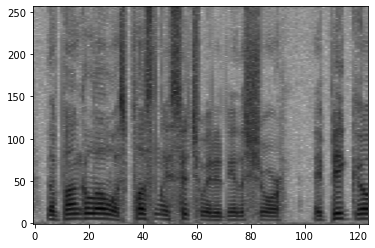

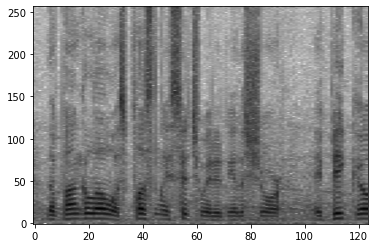

In [6]:
clear=data_clear.__getitem__(0)[0][0]
noisy=data_noisy.__getitem__(0)[0][0]

plt.figure(0)
plt.imshow(clear, cmap='gray', aspect='auto', origin='lower')

plt.figure(1)
plt.imshow(noisy, cmap='gray', aspect='auto', origin='lower')

In [7]:
# path = '../Data/test/Dataset/'
# noisy = my_loader(path+'bruite/Data/b_sig_1_0.npy')
# clear = my_loader(path+'non_bruite/Data/nb_sig_1_0.npy')

# clear = my_loader('../Data/Spec_TEST/Clear/Modulus/Data/c_sig_2_0_mod.npy')
# noisy = my_loader('../Data/Spec_TEST/Noisy/Modulus/Data/n_sig_2_0_mod.npy')



# plt.figure(0)
# plt.imshow(clear, cmap='gray', aspect='auto', origin='lower')

# plt.figure(1)
# plt.imshow(noisy, cmap='gray', aspect='auto', origin='lower')


In [8]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer1 = nn.Conv2d(
            in_channels=1, out_channels=512, kernel_size=(25, 25), padding=(0,0)
        )
        self.encoder_hidden_layer2 = nn.Conv2d(
            in_channels=512, out_channels=100, kernel_size=(15, 15), padding=(3,0)
        )
        self.encoder_hidden_layer3 = nn.Conv2d(
            in_channels=100, out_channels=10, kernel_size=(15, 15), padding=(0, 1)
        )
        self.poolp = nn.MaxPool2d(
            kernel_size=2, padding=(0,1)
        )
        self.pool = nn.MaxPool2d(
            kernel_size=2
        )
        self.decoder_hidden_layer1 = nn.ConvTranspose2d(
            in_channels=10, out_channels=100, kernel_size=(15, 15), stride=2, padding=(0,0)
        )
        self.decoder_hidden_layer2 = nn.ConvTranspose2d(
            in_channels=100, out_channels=512, kernel_size=(15, 15), stride=2, padding=(0,0)
        )
        self.decoder_output_layer = nn.ConvTranspose2d(
            in_channels=512, out_channels=1, kernel_size=(25, 25), stride=2, padding=(2,0)
        )



    def forward(self, features):
#         print("features", features.size())

        encode1 = self.encoder_hidden_layer1(features)
        encode1 = torch.relu(encode1)
        encode1 = self.pool(encode1)
#         print("couche encode 1", encode1.size())

        encode2 = self.encoder_hidden_layer2(encode1)
        encode2 = torch.relu(encode2)
        encode2 = self.pool(encode2)
#         print("couche encode 2", encode2.size())

        encode3 = self.encoder_hidden_layer3(encode2)
        encode3 = torch.relu(encode3)
        encode3 = self.pool(encode3)
#         print("couche encode 3", encode3.size())

        decode1 = self.decoder_hidden_layer1(encode3)
        decode1 = torch.relu(decode1)
#         print("couche decode 1", decode1.size())

        decode2 = self.decoder_hidden_layer2(decode1)
        decode2 = torch.relu(decode2)
#         print("couche decode 2", decode2.size())

        decode3 = self.decoder_output_layer(decode2)
        decode3 = torch.relu(decode3)
#         print("couche decode 3", decode3.size())

        decode3 = decode3[:, :, 0:features.size()[2], 0:features.size()[3]]

#         print("couche decode 3 crop", decode3.size())
        return decode3
        
 



In [9]:
# #  use gpu if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if (device == "cuda"):
    torch.cuda.empty_cache()

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# mean-squared error loss
criterion = nn.MSELoss()

In [10]:
# load model
# model = AE().to(device)
# model.load_state_dict(torch.load("model_V0/model19.pt"))
# model.train()

for epoch in range(epochs):
    loss = 0
#     for batch_features, _ in test_loader:
    for [batch_features,_],[batch_features_clear,_] in zip(test_loader, test_loader_clear):
        batch_features = batch_features.to(device)
        batch_features_clear = batch_features_clear.to(device)
#         print(batch_features.type())
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        # compute reconstructions
#         outputs = model(torch.tensor(batch_features, device=device))
        outputs = model(batch_features.clone().detach())


#         outputs = model(batch_features)

#         print(outputs.size())
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features_clear)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(test_loader)
    
    # save the weigth
    torch.save(model.state_dict(), "model/model"+str(epoch+1)+".pt")
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 0.04770520
epoch : 2/20, recon loss = 0.02062801
epoch : 3/20, recon loss = 0.01975099
epoch : 4/20, recon loss = 0.01937239
epoch : 5/20, recon loss = 0.01912723


KeyboardInterrupt: 

In [13]:
########################### Prédiction


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE().to(device)
# model = autoencoder().to(device)


# load model
model.load_state_dict(torch.load("model/model2.pt"))
model.eval()

with torch.no_grad():
    i=0
    for batch_features, _ in test_loader:
        batch_features = batch_features.to(device)
#         print(type(batch_features))
        outputs = model(batch_features.clone().detach())
#         print(type(outputs))
        np.save('../Data/test/Predict/output_' + str(i) + '.npy', outputs.cpu().numpy().astype(np.float32))
        i+=1









0.7127198

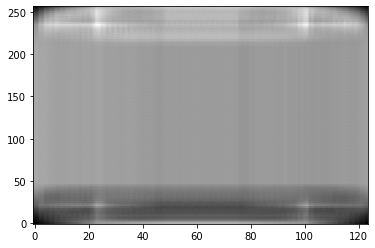

In [14]:
name = "output_1"
path = "../Data/test/Predict/"
spec = np.load(path+name+".npy")
plt.imshow(spec[0][0], cmap='gray', aspect='auto', origin='lower')
np.max(spec[0][0])

In [ ]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
print(output)
output.backward()
print(input)
print(target)
print(output)


In [ ]:
from scipy.signal import istft
import cmath
from scipy.io.wavfile import write
nprect = np.vectorize(cmath.rect)


waveform, sample_rate = torchaudio.load("../Data/meme_taille_TEST/sig_1_0.WAV")
phase, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = False, mode = 'phase', cmap = 'gray')
magnitude, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = False, mode = 'magnitude', cmap = 'gray')

spec = nprect(magnitude, phase)

sig = istft(spec, fs=sample_rate, nfft=512, nperseg=512, noverlap=128)
print(np.shape(waveform))
print(np.shape(sig))

plt.figure(0)
plt.plot(sig[0], sig[1])

write("coucou.wav",sample_rate,sig[1])

In [ ]:
magnitude

In [ ]:
norm = (np.max(magnitude)-np.min(magnitude))
mag_norm = magnitude/norm
mag_norm

In [ ]:
mag_db = 20*np.log10(mag_norm)
mag_db

In [ ]:
a = 10**(mag_db/20)
plt.imshow(a, cmap='gray', aspect='auto', origin='lower')
a

In [ ]:
b = a * norm 
b

In [ ]:
spec = nprect(b, phase)
sig = istft(spec, fs=sample_rate, nfft=512, nperseg=512, noverlap=128)
print(np.shape(waveform))
print(np.shape(sig))

plt.figure(0)
plt.plot(sig[0], sig[1])

write("coucou_n.wav",sample_rate,sig[1])

In [ ]:
from scipy.signal import istft
import cmath
from scipy.io.wavfile import write
nprect = np.vectorize(cmath.rect)


spec_db = np.load("../Data/test/Predict/output_1.npy")[0][0]
magnitude = 10**(-spec_db/20)
phase = np.load("../Data/Spec_TEST_SNR_5/Noisy/Phase/n_sig_1_0_phi.npy")

waveform, sample_rate = torchaudio.load("../Data/meme_taille_TEST/sig_1_0.WAV")
# phase, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = False, mode = 'phase', cmap = 'gray')
# magnitude, f_br, t_br, im_br = plt.specgram(waveform[0].t().numpy(), Fs = sample_rate, NFFT = 512, scale_by_freq = False, mode = 'magnitude', cmap = 'gray')

spec = nprect(magnitude, phase)

sig = istft(spec, fs=sample_rate, nfft=512, nperseg=512, noverlap=128)
print(np.shape(waveform))
print(np.shape(sig))

plt.figure(0)
plt.plot(sig[0], sig[1])

write("coucou_den.wav",sample_rate,sig[1])